# Tutorial 2 – Parameter Estimation

In the second example we will be looking at a parameter estimation problem where we combine most of the elements discussed in the Overview section of this document. This example is the same reaction system as Tutorial 1, except in this case we use a simulated data set as our input D-matrix. This example, while not too computationally complex provides a good overview of all the capabilities of KIPET.

### Load required modules

In [21]:
import inspect
import os
import sys

import matplotlib.pyplot as plt

from kipet.library.common.charts import make_plot
from kipet.library.data_tools import *
from kipet.library.ParameterEstimator import *
from kipet.library.PyomoSimulator import *
from kipet.library.TemplateBuilder import *
from kipet.library.VarianceEstimator import *

### Reading data

Firstly we will need to input our D-matrix, which contains the spectral data. More notes on the structure of these data files and which file types are permitted are included in the section on data files. In order to do this we need to point the model to the data file. We can do this by using the following lines:

In [22]:
dataDirectory = os.path.abspath(
        os.path.join( os.path.dirname( os.path.abspath( inspect.getfile(
            inspect.currentframe() ) ) ), 'data_sets'))
filename =  os.path.join(dataDirectory,'Dij.txt')
D_frame = read_file(filename)

read dir : /home/kevin/Dev/kipet/kipet/examples/data_sets/Dij.txt


### Load required modules

In [21]:
import inspect
import os
import sys

import matplotlib.pyplot as plt

from kipet.library.common.charts import make_plot
from kipet.library.data_tools import *
from kipet.library.ParameterEstimator import *
from kipet.library.PyomoSimulator import *
from kipet.library.TemplateBuilder import *
from kipet.library.VarianceEstimator import *

where dataDirectory points to the folder/directory where the data file is found. The ‘..’ refers to changing directory back one and ‘data_sets’ is the name of the folder where the data file is found. The filename refers to the exact location of the data file, ‘Dij.txt’. Finally we define the D_frame which uses the KIPET function:

```read_spectral_data_from_text()```

### TemplateBuilder

The TemplateBuilder is constructed in the same way as in the previous example, except in this case we add the parameters with bounds as opposed to fixed values. This is done in the following way:

In [23]:
builder = TemplateBuilder()    
components = {'A':1e-3,'B':0,'C':0}
builder.add_mixture_component(components)
builder.add_parameter('k1', init=4.0, bounds=(0.0,5.0)) 

#There is also the option of providing initial values: Just add init=... as additional argument as above.
builder.add_parameter('k2', init=2, bounds=(0.0, 1.0))
builder.add_spectral_data(D_frame)

# define explicit system of ODEs
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    exprs['B'] = m.P['k1']*m.Z[t,'A']-m.P['k2']*m.Z[t,'B']
    exprs['C'] = m.P['k2']*m.Z[t,'B']
    return exprs

builder.set_odes_rule(rule_odes)
builder.bound_profile(var='S', bounds=(0, 200))
opt_model = builder.create_pyomo_model(0.0,10.0)

The components, ODEs, and the optimization problem are all set up in the same way as was previously explained.

### VarianceEstimator

After the Pyomo model is set up with the TemplateBuilder the VarianceEstimator is called, followed by the discretization scheme, as was previously shown:

In [24]:
v_estimator = VarianceEstimator(opt_model)
v_estimator.apply_discretization('dae.collocation',
                                 nfe = 60,
                                 ncp = 1,
                                 scheme = 'LAGRANGE-RADAU')

    number of finite elements specified in apply. The larger number of finite
    elements will be used.


The next section of code run the optimization procedure described in the Overview section and detailed in Chen, et al. (2016).

In [25]:
options = {}
    
A_set = [l for i,l in enumerate(opt_model.meas_lambdas) if (i % 4 == 0)]
    
# Finally we run the variance estimatator using the arguments shown in Seciton 4.3.3
results_variances = v_estimator.run_opt('ipopt',
                                        tee=True,
                                        solver_options=options,
                                        tolerance=1e-5,
                                        max_iter=15,
                                        subset_lambdas=A_set)



Default method of originalchenetal selected
The available methods are originalchenetal, direct_sigmas, alternate
Solving Initialization Problem

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     6003
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    70050

Total number of variables............................:     1880
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       77
   

Where the solver is ’ipopt’, tee = True is to stream the optimizer output to the console, solver options are related to the IPOPT solver and can be viewed in the IPOPT manual. In the case of this example, no options are given to the solver and allowing KIPET to provide good default options. The tolerance argument is the tolerance required for the termination of the variance estimator for the change in Z between iterations, as described in the paper. The max_iter argument is for the maximum number of iterations of the iterative procedure described in Figure 4. subset_lambdas = A_set is the set of wavelengths to use in initializing the problem, default=all. For large problems it might be worth making that smaller as it allows the VarianceEstimator a smaller set to work with. For problems with a lot of noise, this can be very useful and was shown in the paper to be equally effective as including the entire set of wavelengths. A_set in this example is set to be every fourth value. After the VarianceEstimator iterative procedure is completed, the results can then be printed:

In [26]:
print("\nThe estimated variances are:\n")
for k, v in results_variances.sigma_sq.items():
    print(k, v)

# and the sigmas for the parameter estimation step are now known and fixed
sigmas = results_variances.sigma_sq


The estimated variances are:

C 9.625664603500908e-11
B 1.6455641985807274e-10
A 1.0888292513884262e-10
device 3.2888861572533785e-06


Where the “device” refers to the measurement error.

### ParameterEstimator

After rewriting the Pyomo model created from the VarianceEstimator, the ParameterEstimator function is created:

In [27]:
opt_model = builder.create_pyomo_model(0.0,10.0)
p_estimator = ParameterEstimator(opt_model)

Discretization is then applied to the p_estimator, as in the previous example, and before running the ParameterEstimator optimization we can use the VarianceEstimator’s results in order to initialize the p_estimator model. This is only possible if the VarianceEstimator is used, but it can also be omitted. Note that the discretization of the p_estimator has to be done with the same element and collocation point placement in order to maximize the benefits of the initialization step.

In [28]:
p_estimator.apply_discretization('dae.collocation',
                                 nfe = 60,
                                 ncp = 1,
                                 scheme='LAGRANGE-RADAU')

p_estimator.initialize_from_trajectory('Z',results_variances.Z)
p_estimator.initialize_from_trajectory('S',results_variances.S)
p_estimator.initialize_from_trajectory('C',results_variances.C)

    number of finite elements specified in apply. The larger number of finite
    elements will be used.


IPOPT performs rudimentary scaling of variables automatically. Some problems may, however, require more detailed scaling information so that IPOPT can perform in an efficient manner. In order to use the scaling information from the previous optimization we may use the following:

In [29]:
p_estimator.scale_variables_from_trajectory('Z',results_variances.Z)
p_estimator.scale_variables_from_trajectory('S',results_variances.S)
p_estimator.scale_variables_from_trajectory('C',results_variances.C)

Once again, this step is not a necessity for all problems, particularly those that are well-scaled for IPOPT. If this variable scaling is included then the optimization step will need to include the NLP scaling option, as demonstrated below:

In [30]:
options = dict()
options['nlp_scaling_method'] = 'user-scaling'

results_pyomo = p_estimator.run_opt('ipopt',
                                  tee=True,
                                  solver_opts = options,
                                  variances=sigmas)


Ipopt 3.13.2: nlp_scaling_method=user-scaling


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     6003
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   274800

Total number of variables............................:     3005
                     variables with only lower bounds:      900
                variables with lower and upper bounds:      302
                     variables with only upper bounds:        0
Total number of equality constraints................

Where the additional argument, variances = sigmas, refers to the fact that we are including the variances calculated by the VarianceEstimator.

### Visualize the Results

The estimated parameters are:
k1 0.2618063661921968
k2 1.0


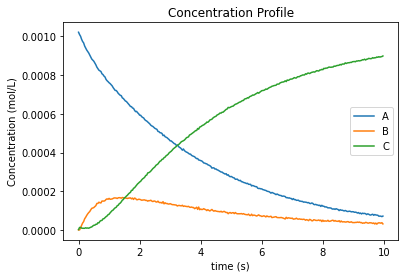

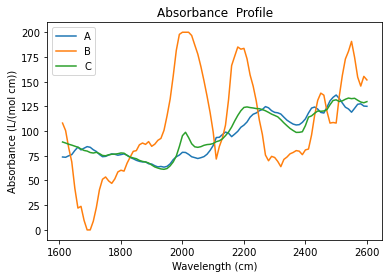

In [35]:
 print("The estimated parameters are:")
for k, v in results_pyomo.P.items():
    print(k, v)


results_pyomo.C.plot.line(legend=True)
plt.xlabel("time (s)")
plt.ylabel("Concentration (mol/L)")
plt.title("Concentration Profile")

results_pyomo.S.plot.line(legend=True)
plt.xlabel("Wavelength (cm)")
plt.ylabel("Absorbance (L/(mol cm))")
plt.title("Absorbance  Profile")

plt.show()

### Confidence intervals

If the user would like to assess the level of confidence in the estimated parameters the run_opt function needs to be changed. And example of this is found in the Example labeled “Ex_2_estimation_conf.py” in the Examples folder. Firstly the ‘k_aug’ solver needs to be called. Additionally, the option for the covariance needs to be changed from the default. More information on the ParameterEstimator function is found in section 5.